In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure1'

In [3]:
subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')

In [4]:
import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
data_dir_full = subdb.iloc[0]['data_dir_full']

In [52]:
import glob
SleepState = glob.glob(os.path.join(data_dir_full,'*SleepState.states.mat'))[0]
SleepState  = dpn.loadmat_full(SleepState,'SleepState')

cell_metrics=glob.glob(os.path.join(data_dir_full,'*cell_metrics.cellinfo.mat'))[0]
cell_metrics = dpn.loadmat_full(cell_metrics,'cell_metrics')

mergepoints=glob.glob(os.path.join(data_dir_full,'*MergePoints*.mat'))[0]
mergepoints = dpn.loadmat_full(mergepoints,'MergePoints')

In [43]:
SleepState.detectorinfo

['detectorname', 'detectionparms', 'detectiondate', 'StatePlotMaterials']

In [147]:
def group_intervals_by_intervals(int_l_to_be_grouped,int_l):
    '''
    discard ones that can't fit in
    '''
    int_l_to_be_grouped_selected=[]
    group_l = []
    for intvl in int_l_to_be_grouped:
        one_diff=intvl - int_l
        which_group = np.nonzero((one_diff[:,0] >= 0) & (one_diff[:,1] <= 0))[0]
        if len(which_group)>0:
            which_group = which_group[0]
            group_l.append(which_group)
            int_l_to_be_grouped_selected.append(intvl)
    int_l_to_be_grouped_selected = np.array(int_l_to_be_grouped_selected)
    group_l = np.array(group_l)
    groups = np.unique(group_l)
    int_l_grouped = {}
    for g in groups:
        ma = group_l==g
        int_l_grouped[g] = int_l_to_be_grouped_selected[ma]
    
    return int_l_grouped
        
def group_intervals_pre_post(int_l_to_be_grouped,bounds):
    '''
    discard ones that can't fit in
    '''
    int_l_to_be_grouped_selected=[]
    group_l = []
    
    pre_mask = np.all(int_l_to_be_grouped <= bounds[0],axis=1)
    post_mask = np.all(int_l_to_be_grouped >= bounds[1],axis=1)
    int_l_grouped = {'pre':int_l_to_be_grouped[pre_mask],
                     'post':int_l_to_be_grouped[post_mask]}
    return int_l_grouped
    

        

        

In [63]:
int_l_to_be_grouped = nrem_intvl
int_l = merge_intvl
int_l_grouped = group_intervals_by_intervals(int_l_to_be_grouped,int_l)

In [66]:
def get_frac_sleep(int_l):
    dur = int_l[-1][-1] - int_l[0][0]
    tot_dur = np.sum(np.diff(int_l,axis=1))
    frac=tot_dur/dur
    return frac
    

In [90]:
def get_fr_within_intervals_one_cell(times,int_l):
    edges=int_l.flatten()
    counts,_ = np.histogram(times,edges)
    counts_within = counts[::2]
    counts_tot = np.sum(counts_within)
    dur_tot = np.sum(np.diff(int_l,axis=1))
    fr = counts_tot / dur_tot
    return fr, counts_tot, dur_tot

def get_fr_within_grouped_intervals_all_cell(spike_times,int_l_grouped,uid=None):
    fr_within_intervals_grouped={}
    for g, int_l in int_l_grouped.items():
        fr_within_intervals_one = []
        for times in spike_times:
            fr,ct,dur=get_fr_within_intervals_one_cell(times,int_l)
            fr_within_intervals_one.append(fr)
        
        fr_within_intervals_grouped[g] = np.array(fr_within_intervals_one)
        
    fr_within_intervals_grouped = pd.DataFrame(fr_within_intervals_grouped)
    if uid is not None:
        fr_within_intervals_grouped.index = uid
    
    return fr_within_intervals_grouped
    

In [85]:
times = cell_metrics['spikes']['times'][10]
int_l = int_l_grouped[0]
get_fr_within_intervals_one_cell(times,int_l)

(18.30184522170201, 66454, 3631)

In [91]:
spike_times = cell_metrics['spikes']['times']
uid = cell_metrics['UID']
fr_within_intervals_grouped = get_fr_within_grouped_intervals_all_cell(spike_times,int_l_grouped,uid=uid)

In [95]:
sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True)
pval = sw_res['pval']
best_n = sw_res['best_n']
sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
all_sw_d = sw_info_res['all_sw_d']

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info.p exists; loading---


In [100]:
SleepState.ints.NREMstate

array([[  228,   241],
       [  250,   260],
       [  303,   323],
       [  363,   422],
       [  438,   466],
       [  492,   534],
       [  550,   659],
       [  674,   706],
       [  715,   795],
       [  806,   952],
       [  968,  1015],
       [ 1024,  1159],
       [ 1183,  1337],
       [ 1464,  1473],
       [ 1743,  1750],
       [ 1867,  1875],
       [ 1885,  1892],
       [ 1914,  1922],
       [ 2217,  2275],
       [ 2294,  2351],
       [ 2674,  2785],
       [ 2798,  2923],
       [ 2953,  3043],
       [ 3054,  3281],
       [ 3292,  3442],
       [ 3594,  3777],
       [ 3788,  3825],
       [ 3848,  3899],
       [ 3926,  3953],
       [ 3962,  4005],
       [ 4202,  4209],
       [ 4256,  4394],
       [ 5168,  5187],
       [ 5286,  5342],
       [ 5368,  5473],
       [ 5483,  5515],
       [ 5555,  5616],
       [ 5626,  5819],
       [ 5829,  5960],
       [ 5983,  6335],
       [ 6370,  6604],
       [ 6624,  6655],
       [ 6672,  6711],
       [ 67

In [144]:
int_l_to_be_grouped

array([[ 1582,  3056],
       [ 3242,  3698],
       [ 3770,  4105],
       [ 4410,  4817],
       [ 4849,  5052],
       [10222, 10709],
       [10926, 11091],
       [11246, 11917],
       [12129, 12379],
       [12440, 12953],
       [16103, 16983],
       [17061, 17523],
       [18404, 18885],
       [22781, 23625],
       [23900, 24350],
       [24579, 25193],
       [29279, 29651]], dtype=uint16)

In [149]:
def get_fr_diff_sw_on_off_vs_non_sw(cell_metrics,beh_time_bounds,all_sw_d,best_n,SleepState):
    '''
    get fr difference post - pre, also categorize into: only having switching on, only having switching off, no switching, neurons
    post_minus_pre_fr_df: df: n_neurons x ['post_minus_pre','fr_post','fr_pre','switch_category']
    '''
    all_sw_d['switch_on'] = all_sw_d['switch']==1
    all_sw_d['switch_off'] = all_sw_d['switch']==-1
    on_ma = all_sw_d.groupby('uid')['switch_on'].all()
    off_ma = all_sw_d.groupby('uid')['switch_off'].all()
    
    ntasks = len(best_n.index.get_level_values(0).unique())
    uid = cell_metrics['UID']
    spk_times_l = cell_metrics['spikes']['times']
    interval_l = mergepoints['timestamps']

    


    no_sw_ma = (best_n == 0).groupby(level=2).all()
#     pdb.set_trace()
    
    assert np.diff(interval_l[1 +ntasks]) > (10 * 60) # each sleep epoch at least 10min
    assert np.diff(interval_l[0])> (10 * 60)
    
    int_l_to_be_grouped = SleepState.ints.NREMstate
    int_l_grouped=group_intervals_pre_post(int_l_to_be_grouped,beh_time_bounds)

    
    spike_times = cell_metrics['spikes']['times']
    uid = cell_metrics['UID']
    fr_within_intervals_grouped = get_fr_within_grouped_intervals_all_cell(spike_times,int_l_grouped,uid=uid)
#     pdb.set_trace()
    post_minus_pre_fr = (fr_within_intervals_grouped['post'] - fr_within_intervals_grouped['pre']).values # assuming 0-pre and 2-post for 1 task, 3-post for 2 tasks
    post_minus_pre_fr_df =pd.DataFrame(post_minus_pre_fr,columns=['post_minus_pre'],index=uid)
    post_minus_pre_fr_df['fr_post'] = fr_within_intervals_grouped['post']
    post_minus_pre_fr_df['fr_pre'] = fr_within_intervals_grouped['pre']
    
    sw_category = np.zeros(post_minus_pre_fr_df.shape[0]) * np.nan
    sw_category = pd.Series(sw_category,index=uid)
    sw_category[on_ma.loc[on_ma].index] = 'on'
    sw_category[off_ma.loc[off_ma].index] = 'off'
    sw_category[no_sw_ma.loc[no_sw_ma].index] = 'no_switch'
    
    post_minus_pre_fr_df['switch_category'] = sw_category
    post_minus_pre_fr_df = post_minus_pre_fr_df.dropna(axis=0)


    return post_minus_pre_fr_df
    
    

In [151]:
post_minus_pre_fr_df = get_fr_diff_sw_on_off_vs_non_sw(cell_metrics,beh_time_bounds,all_sw_d,best_n,SleepState)

/tmp/ipykernel_744848/2622159086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_d['switch_on'] = all_sw_d['switch']==1
/tmp/ipykernel_744848/2622159086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_d['switch_off'] = all_sw_d['switch']==-1


In [132]:
int_l = mergepoints['timestamps']
int_l_to_be_grouped = SleepState['ints']['NREMstate']

In [135]:
sess

'e15_13f1_220118'

In [137]:
spk_beh_df=dpp.load_spk_beh_df(data_dir_full,load_only=True)

In [139]:
spk_beh_df['beh_df']

,time,lin,x,y,trial,task_index,task,vx_raw,vy_raw,speed_raw,...,theta_data,trial_type,segment,dist_to_maze,off_track,on_track,off_track_event,pause_event,directed_locomotion,low_speed
0,5636.726033,9.393281,71.727893,51.859847,NaN,0,alternation,0.226139,0.501319,0.549963,...,60.943296,None,NaN,6.385200,True,False,True,False,False,False
1,5636.759367,9.393281,71.735431,51.876557,NaN,0,alternation,0.179176,0.635181,0.659969,...,-496.867256,None,NaN,6.402462,True,False,True,False,False,False
2,5636.792700,9.393281,71.739838,51.902192,NaN,0,alternation,-0.044688,0.822785,0.823997,...,-95.980196,None,NaN,6.428369,True,False,True,False,False,False
3,5636.826033,9.393281,71.732452,51.931410,NaN,0,alternation,-1.409345,0.654914,1.554080,...,318.807202,None,NaN,6.456898,True,False,True,False,False,False
4,5636.859400,9.482741,71.645882,51.945853,NaN,0,alternation,-4.380049,-0.235340,4.386367,...,136.652657,None,NaN,6.464989,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119559,15046.318867,93.012603,18.211023,17.041368,67.0,1,linearMaze,NaN,NaN,1.650330,...,-238.211544,"(1, 1)",NaN,7.687833,True,False,False,False,False,True
119560,15046.352200,92.902581,18.102073,17.150322,67.0,1,linearMaze,NaN,NaN,4.950990,...,477.385377,"(1, 1)",NaN,7.562980,True,False,False,False,False,True
119561,15046.385533,92.682537,17.942868,17.375397,67.0,1,linearMaze,NaN,NaN,7.591518,...,-362.998612,"(1, 1)",NaN,7.361771,True,False,False,False,False,True
119562,15046.418900,92.396479,17.812596,17.670634,67.0,1,linearMaze,NaN,NaN,8.581716,...,-305.539631,"(1, 1)",NaN,7.183059,True,False,False,False,False,True


In [133]:
int_l

array([[    0.        ,  5616.60796667],
       [ 5616.608     ,  7716.63996667],
       [ 7716.64      , 13105.59996667],
       [13105.6       , 15049.02396667],
       [15049.024     , 19118.94396667],
       [19118.944     , 21627.77596667],
       [21627.776     , 27902.77596667],
       [27902.776     , 29653.11196667]])

In [134]:
group_intervals_by_intervals(int_l_to_be_grouped,int_l)

{0: array([[1582, 3056],
        [3242, 3698],
        [3770, 4105],
        [4410, 4817],
        [4849, 5052]], dtype=uint16),
 2: array([[10222, 10709],
        [10926, 11091],
        [11246, 11917],
        [12129, 12379],
        [12440, 12953]], dtype=uint16),
 4: array([[16103, 16983],
        [17061, 17523],
        [18404, 18885]], dtype=uint16),
 6: array([[22781, 23625],
        [23900, 24350],
        [24579, 25193]], dtype=uint16),
 7: array([[29279, 29651]], dtype=uint16)}

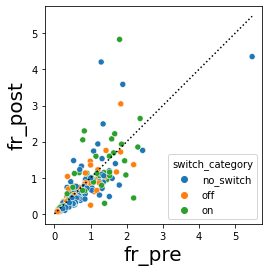

In [113]:
fig,ax=plt.subplots()
ax.set_aspect('equal')
data=post_minus_pre_fr_df
sns.scatterplot(data=data,x='fr_pre',y='fr_post',hue='switch_category',ax=ax)
dmax=np.maximum(data['fr_post'].max(),data['fr_pre'].max())
ax.plot([0,dmax],[0,dmax],color='k',linestyle=':')

In [97]:
get_fr_within_intervals_one_cell

<function __main__.get_fr_within_intervals_one_cell(times, int_l)>

In [142]:
%%time
import glob
# load cell metrics
cell_metrics_all = {}
mergepoints_all = {}
SleepState_all = {}
beh_time_bounds_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    cell_metrics=glob.glob(os.path.join(data_dir_full,'*cell_metrics.cellinfo.mat'))[0]
    cell_metrics = dpn.loadmat_full(cell_metrics,'cell_metrics')
    cell_metrics_all[ani,sess] = cell_metrics
    
    mergepoints=glob.glob(os.path.join(data_dir_full,'*MergePoints*.mat'))[0]
    mergepoints = dpn.loadmat_full(mergepoints,'MergePoints')
    mergepoints_all[ani,sess] = mergepoints
    
    SleepState = glob.glob(os.path.join(data_dir_full,'*SleepState.states.mat'))[0]
    SleepState  = dpn.loadmat_full(SleepState,'SleepState')
    SleepState_all[ani,sess] = SleepState
    
    res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
    beh_df=res['beh_df']
    beh_time_bounds=beh_df['time'].iloc[0],beh_df['time'].iloc[-1]
    beh_time_bounds_all[ani,sess] = beh_time_bounds


CPU times: user 7.53 s, sys: 3.51 s, total: 11 s
Wall time: 11.1 s


In [115]:
%%time
all_fields_recombined_all = {}
pf_params_recombined_all = {}
fr_map_trial_df_all = {}
pval_all = {}
best_n_all = {}
X_pwc_all = {}
X_raw_all = {}
changes_df_all = {}
var_res_all = {}
corr_all = {}
all_sw_d_all = {}
all_sw_with_metrics_d_all = {}
trial_index_to_index_within_df_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
    if res is not None:
        spk_beh_df = res['spk_beh_df']
        trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
        trial_index_to_index_within_df_all[ani,sess] = trial_index_to_index_within_df
        

    pf_res_recombine = pfrc.main(data_dir_full,force_reload=False,load_only=True)

    all_fields_recombined=pf_res_recombine['all_fields_recombined']
    all_fields_recombined_all[ani,sess] = all_fields_recombined
    pf_params_recombined = pf_res_recombine['params_recombined']
    pf_params_recombined_all[ani,sess] = pf_params_recombined

    fr_map_all = fmos.main(data_dir_full,force_reload=False,load_only=True)
    fr_map_trial_df = fr_map_all['fr_map_trial_df']
    fr_map_trial_df_all[ani,sess] = fr_map_trial_df



    sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True)
    pval = sw_res['pval']
    pval_all[ani,sess]=pval
    best_n = sw_res['best_n']
    best_n_all[ani,sess] = best_n
    X_pwc = sw_res['X_pwc']
    X_pwc_all[ani,sess] = X_pwc
    X_raw = sw_res['X_raw']
    X_raw_all[ani,sess]=X_raw
    changes_df = sw_res['changes_df']
    changes_df_all[ani,sess] = changes_df
    var_res = sw_res['var_res']
    var_res_all[ani,sess]=var_res
    corr = sw_res['corr']
    corr_all[ani,sess] = corr

    sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
    if sw_info_res is None:
        sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res['all_sw_d']
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res['all_sw_with_metrics_d']
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d

all_fields_recombined_all = pd.concat(all_fields_recombined_all,axis=0)
pf_params_recombined_all = pd.concat(pf_params_recombined_all,axis=0)
fr_map_trial_df_all = pd.concat(fr_map_trial_df_all,axis=0)
pval_all = pd.concat(pval_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
all_sw_d_all = pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)
best_n_all = pd.concat(best_n_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/sw_res_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/switch_analysis/all_sw_info.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/place_fie

# get pre post sleep fr all

In [152]:
post_minus_pre_fr_df_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    cell_metrics = cell_metrics_all[ani,sess]
    mergepoints = mergepoints_all[ani,sess]
    SleepState = SleepState_all[ani,sess]    
    beh_time_bounds = beh_time_bounds_all[ani,sess]
    
    all_sw_d = all_sw_d_all.loc[ani,sess]
    best_n = best_n_all.loc[ani,sess]
    
    
    
    post_minus_pre_fr_df = get_fr_diff_sw_on_off_vs_non_sw(cell_metrics,beh_time_bounds,all_sw_d,best_n,SleepState)
    post_minus_pre_fr_df_all[ani,sess]=post_minus_pre_fr_df
post_minus_pre_fr_df_all = pd.concat(post_minus_pre_fr_df_all,axis=0)

/tmp/ipykernel_744848/807842203.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d = all_sw_d_all.loc[ani,sess]
/tmp/ipykernel_744848/807842203.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_n = best_n_all.loc[ani,sess]
/tmp/ipykernel_744848/2622159086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_d['switch_on'] = all_sw_d['switch']==1
/tmp/ipykernel_744848/2622159086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_744848/807842203.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d = all_sw_d_all.loc[ani,sess]
/tmp/ipykernel_744848/807842203.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_n = best_n_all.loc[ani,sess]
/tmp/ipykernel_744848/2622159086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_d['switch_on'] = all_sw_d['switch']==1
/tmp/ipykernel_744848/2622159086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_744848/807842203.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d = all_sw_d_all.loc[ani,sess]
/tmp/ipykernel_744848/807842203.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_n = best_n_all.loc[ani,sess]
/tmp/ipykernel_744848/2622159086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_d['switch_on'] = all_sw_d['switch']==1
/tmp/ipykernel_744848/2622159086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_744848/807842203.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d = all_sw_d_all.loc[ani,sess]
/tmp/ipykernel_744848/807842203.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_n = best_n_all.loc[ani,sess]
/tmp/ipykernel_744848/2622159086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_d['switch_on'] = all_sw_d['switch']==1
/tmp/ipykernel_744848/2622159086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_744848/807842203.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d = all_sw_d_all.loc[ani,sess]
/tmp/ipykernel_744848/807842203.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_n = best_n_all.loc[ani,sess]
/tmp/ipykernel_744848/2622159086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_d['switch_on'] = all_sw_d['switch']==1
/tmp/ipykernel_744848/2622159086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_744848/807842203.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d = all_sw_d_all.loc[ani,sess]
/tmp/ipykernel_744848/807842203.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_n = best_n_all.loc[ani,sess]
/tmp/ipykernel_744848/2622159086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_d['switch_on'] = all_sw_d['switch']==1
/tmp/ipykernel_744848/2622159086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [153]:
post_minus_pre_fr_df_all

post_minus_pre    fr_post    fr_pre  \
e13_26m1 e13_26m1_210913 27.0       -1.117034   4.353911  5.470945   
                         30.0        1.144519   2.490705  1.346186   
                         31.0        1.210091   3.045949  1.835858   
                         34.0       -0.613415   0.984216  1.597632   
                         39.0       -0.499496   0.949141  1.448637   
...                                       ...        ...       ...   
e14_2m3  e14_2m3_201118  46.0       -0.741223   1.246325  1.987548   
                         47.0       -1.654483   1.050498  2.704981   
                         48.0        2.966641  10.959697  7.993056   
                         50.0        0.122547   0.862968  0.740421   
                         53.0       -1.906943   1.080844  2.987787   

                              switch_category  
e13_26m1 e13_26m1_210913 27.0       no_switch  
                         30.0       no_switch  
                         31.0             off  
                         34.0       no_switch  
                         39.0              on  
...                                       ...  
e14_2m3  e14_2m3_201118  46.0             off  
                         47.0       no_switch  
                         48.0       no_switch  
                         50.0              on  
                         53.0       no_switch  

[3599 rows x 4 columns]

In [155]:
def get_outlier_mask(data,z_thresh=3):
    data_mean = np.mean(data.values,axis=0,keepdims=True)
    dist = np.linalg.norm(data - data_mean,axis=1)
    z = scipy.stats.zscore(dist)
    ma = z > 3
    return ma
    

In [156]:
outlier=get_outlier_mask(post_minus_pre_fr_df_all[['fr_pre','fr_post']],z_thresh=5)

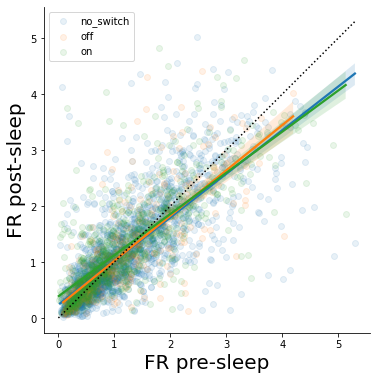

In [158]:
robust = False
fig,ax=plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

data=post_minus_pre_fr_df_all.loc[~outlier]
# data=post_minus_pre_fr_df_all
# data=post_minus_pre_fr_df_all
# for ii,(k,val) in enumerate(post_minus_pre_fr_df_all.groupby('switch_category')): 
for ii,(k,val) in enumerate(data.groupby('switch_category')): 
    sns.regplot(data=val,x='fr_pre',y='fr_post',robust=robust,color=f'C{ii}',label=k,ax=ax,scatter_kws={'alpha':0.1})
bound = np.maximum(data['fr_pre'].max(),data['fr_pre'].max())
ax.plot([0,bound],[0,bound],color='k',linestyle=':')
ax.legend()                                                                            
ax.set(xlabel='FR pre-sleep',ylabel='FR post-sleep')
ax.spines[['top','right']].set_visible(False)
fn = os.path.join(figdir,'fr_post_vs_pre_regplot_outlier_removed.pdf')
# fn = os.path.join(figdir,'fr_post_vs_pre_regplot.pdf')
fig.savefig(fn,bbox_inches='tight')
